## **Project**  
**02805 Social Graphs & Interactions**  

**Group 13** 
- Anna Bøgevang Ekner (s193396)
- Morten Møller Christensen (s204258)


**Inspiration**: 
- https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html
- https://paperswithcode.com/dataset/reddit

Nodes are posts, and there is a link between two posts if the same user has commented on both. 

50 random subreddits, each with 20 top/hot posts from this month.

Each node (post) should have the attributes:

- Title of the post
- Upvotes of the post
- Text of the post
- Subreddit name that the post belongs to
- Usernames of comments on that post

Filter posts with a text below some number of words. 


In [57]:
import os
import praw
import json
import warnings
import random
import networkx as nx
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from dotenv import load_dotenv
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

sns.set_style('darkgrid')
sns.set(font_scale=1.)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## **Part 1: Scraping the data**

#### **Part 1.1: Setting up the Reddit API**

In [2]:
def load_API_tokens():
    # Load environment variables from the .env file
    load_dotenv()

    # Retrieve tokens from environment variables
    client_id = os.getenv('CLIENT_ID')
    client_secret = os.getenv('CLIENT_SECRET')
    user_agent = os.getenv('USER_AGENT')

    return client_id, client_secret, user_agent

In [3]:
# Load API tokens
client_id, client_secret, user_agent = load_API_tokens()

# Initialize Reddit instance with credentials from the .env file
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent
)

#### **Part 1.2: Scraping and saving the data**

Only subreddits with a minimum number of subscribers are chosen. \
Top posts, and only posts with non-empty text are chosen. 

n_subreddits = 50, n_posts_per_subreddit = 20. \
Each subreddit is saved as a .json file that contains:

Subreddit information: 
- Name
- Description
- Subscribers
- Posts

Post information: 
- Title
- Author
- Score
- Text
- Subreddit
- URL
- ID
- Comments

Comment information:
- Author
- Score
- Text
- ID

All of this information is stored in case it could become interesting to use in our exploratory analysis. 


In [4]:
def scrape_reddit_data(n_subreddits, n_posts_per_subreddit, min_subscribers, top_all, data_dir):
    """
    Scrape Reddit data for a given number of random subreddits and save the data to JSON files.

    For {n_subreddits} random subreddits with at least {min_subscribers} subscribers, scrapes the 
    top {n_posts_per_subreddit} posts and comments from the past year and saves the data to JSON files.

    Args 
        n_subreddits: Number of random subreddits to fetch (int)
        n_posts_per_subreddit: Number of top posts to fetch per subreddit (int)
        min_subscribers: Minimum number of subscribers for a subreddit to be included (int)
        top_all: Time frame for top posts (e.g., 'all', 'year', 'month', 'week', 'day', 'hour')
        data_dir: Directory to save the JSON files (str)


    """

    # Number of subreddit JSON files already saved
    saved_subreddits = len(os.listdir(data_dir))

    os.makedirs(data_dir, exist_ok=True)

    while saved_subreddits < n_subreddits:

        # Fetch a random subreddit and validate its subscriber count
        random_subreddit = reddit.subreddit("random")
        random_subreddit = reddit.subreddit("soccer")
        if random_subreddit.subscribers < min_subscribers:
            continue

        print(f"Selected subreddit: {random_subreddit.display_name} with {random_subreddit.subscribers} subscribers")

        # Fetch top posts and initialize data structure
        limit = n_posts_per_subreddit * 1000
        top_posts = random_subreddit.top(top_all, limit=limit)

        subreddit_data = {
            "subreddit": random_subreddit.display_name,
            "description": random_subreddit.public_description,
            "subscribers": random_subreddit.subscribers,
            "posts": []
        }

        # Counter for the number of posts without empty text
        saved_posts = 0

        while saved_posts < n_posts_per_subreddit and len(subreddit_data["posts"]) < n_posts_per_subreddit:

            # Get the next top post
            post = next(top_posts)

            # Skip posts with empty text
            if not post.selftext.strip():
                continue

            post_data = {
                "title": post.title,
                "author": post.author.name if post.author else "deleted",
                "score": post.score,
                "text": post.selftext,
                "subreddit": post.subreddit.display_name,
                "url": post.url,
                "id": post.id,
                "comments": []
            }

            # Fetch up to 10 comments per post
            post.comments.replace_more(limit=0)
            post_data["comments"] = [
                {
                    "comment_id": comment.id,
                    "author": comment.author.name if comment.author else "deleted",
                    "body": comment.body,
                    "score": comment.score
                }
                for comment in post.comments.list()
            ]

            saved_posts += 1
            subreddit_data["posts"].append(post_data)

        # Save subreddit data to a JSON file
        file_path = os.path.join(data_dir, f"{random_subreddit.display_name}.json")
        with open(file_path, "w", encoding="utf-8") as f:
            json.dump(subreddit_data, f, indent=4)

        print(f"Data saved to {file_path}\n")
        saved_subreddits += 1

In [5]:
# Scrape and save Reddit data
scrape_reddit_data(n_subreddits = 50, 
                   n_posts_per_subreddit = 20, 
                   min_subscribers = 100000,
                   top_all = "year", 
                   data_dir = "data")

#### **Part 1.3: Extracting user comment info of each post**
Possibly save a .txt file for each post that contains the usernames of the comments? \
To make it easier to look for intersections between commenters of different posts, when creating the links.

## **Part 2: Building the graph**

In [6]:
def create_graph(data_dir):
    """
    Build the Reddit undirected graph from the scraped data. Nodes are posts, and a 
    link between two nodes is created when the same user comments on both posts.

    Args
        data_dir: Directory containing the subreddit JSON files (str)

    Returns 
        G: Undirected graph representing the Reddit network (nx.Graph)
    """

    # Initialize the graph
    G = nx.Graph()

    # Add nodes for each post
    for file_name in os.listdir(data_dir):
        with open(os.path.join(data_dir, file_name), "r", encoding="utf-8") as f:
            subreddit_data = json.load(f)

        
        for post in subreddit_data["posts"]:
            # Limit the number of comments to reduce the number of edges
            limited_comments = post["comments"]#[:200]
            G.add_node(post["id"], 
                       title = post["title"], 
                       subreddit = post["subreddit"], 
                       text = post["text"], 
                       comments = limited_comments)

    # List of all nodes
    nodes_list = list(G.nodes(data=True))

    common_commenters_within = 0
    common_commenters_across = 0

    # Add links based on shared commenters
    for i, post1 in enumerate(nodes_list):
        for post2 in nodes_list[i+1:]:

            # Get the comments for each post
            post1_comments = post1[1]["comments"]
            post2_comments = post2[1]["comments"]

            # Get the usernames of the commenters for each post
            post1_commenters = set(comment["author"] for comment in post1_comments)
            post2_commenters = set(comment["author"] for comment in post2_comments)
            
            # Remove "deleted" from the sets
            post1_commenters.discard("deleted")
            post1_commenters.discard("deleted")

            post2_commenters.discard("AutoModerator")
            post2_commenters.discard("AutoModerator")


            # Find the common commenters between the two posts
            common_commenters = set(post1_commenters).intersection(post2_commenters)

            if common_commenters:
                G.add_edge(post1[0], post2[0])

                if post1[1]['subreddit'] == post2[1]['subreddit']:
                    common_commenters_within += 1
                else:
                    common_commenters_across += 1

    # Find the largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()

    print(f"Number of common commenters within the same subreddit: {common_commenters_within}")
    print(f"Number of common commenters across different subreddits: {common_commenters_across}")
    
    return G

In [7]:
# Create the Reddit graph
G = create_graph("data")

Number of common commenters within the same subreddit: 7085
Number of common commenters across different subreddits: 12502


In [8]:
print(f"Total number of nodes: {G.number_of_nodes()}")
print(f"Total number of edges: {G.number_of_edges()}")

Total number of nodes: 997
Total number of edges: 19586


## **Part 3: Preliminary analysis of the network**

#### **Part 3.1: Degree distribution**

In [9]:
# Set the number of top nodes to print
n = 5  # Change this to the desired number

# Get the top n nodes with the largest degree
top_n_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:n]
lowest_n_nodes = sorted(G.degree, key=lambda x: x[1], reverse=False)[:n]

# Print the titles of the top n nodes
print(f"Titles of the top {n} nodes with the largest number of connections:")
for node, degree in top_n_nodes:
    print(f"Title: {G.nodes[node]['title']}, Degree: {degree}, url: {G.nodes[node]['subreddit']}")

print(f"Titles of the top {n} nodes with the smallest number of connections:")
for node, degree in lowest_n_nodes:
    print(f"Title: {G.nodes[node]['title']}, Degree: {degree}, url: {G.nodes[node]['subreddit']}")


Titles of the top 5 nodes with the largest number of connections:
Title: A doctor gave me this at work today, Degree: 131, url: HydroHomies
Title: TIFU by not telling my doctor how many Tic-Tacs I eat per day , Degree: 117, url: tifu
Title: Tik Tok by Kesha is going to be really weird for younger people., Degree: 116, url: Showerthoughts
Title: The show lost SO MUCH , Degree: 114, url: brooklynninenine
Title: Funko Pops are Precious Moments figurines for Millenials, Degree: 114, url: Showerthoughts
Titles of the top 5 nodes with the smallest number of connections:
Title: How do restaurants make such rich and deep-flavored sauces?, Degree: 1, url: AskCulinary
Title: I will do one push up for every UPVOTE this post generates!, Degree: 1, url: DecidingToBeBetter
Title: Cannot leave a subreddit. , Degree: 1, url: help
Title: I am schizophrenic. Someone filmed me having a bad episode and shared it on TikTok., Degree: 1, url: legaladvice
Title: Guyzz warning to all of youuu , Degree: 1, url:

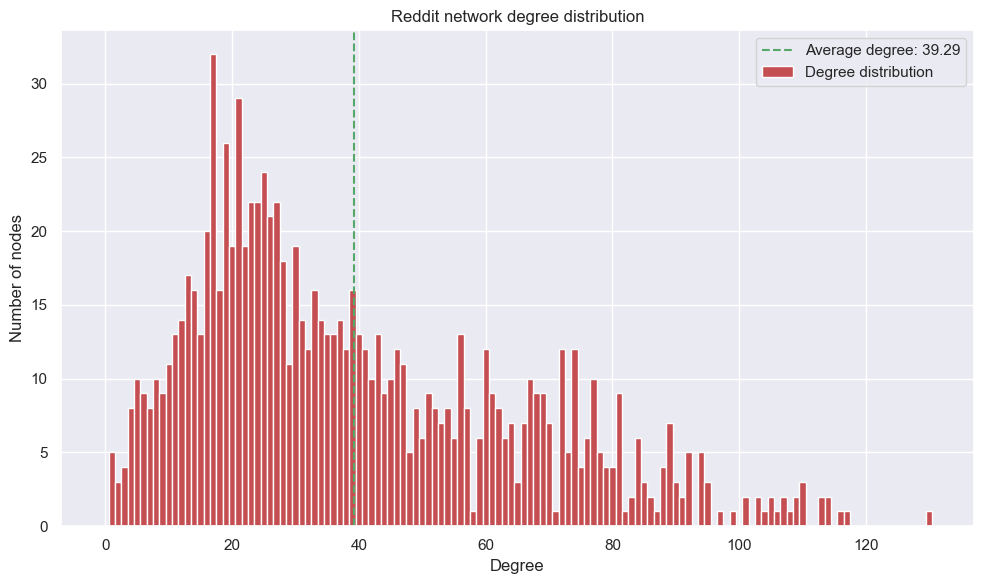

In [10]:
# Degrees in the graph
degrees = [G.degree(n) for n in G.nodes()]
bin_edges = np.linspace(0, max(degrees), max(degrees) + 1)

# Average degree
avg_degree = np.mean(degrees)

counts, bin_edges = np.histogram(degrees, bins=bin_edges)

plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], counts, width=1, label='Degree distribution', color='r')
plt.axvline(avg_degree, color='g', linestyle='--', label=f'Average degree: {avg_degree:.2f}')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Reddit network degree distribution')
plt.legend()
plt.tight_layout()
plt.show()


#### **Part 3.2: Topological and centrality measures**

Measures taken from this example: https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html

**Shortest paths**

In [11]:
# shortest_path_lengths[u][v] will return the shortest path length between any two pair of nodes u and v
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))
print(f"Shortest path between two random nodes: {shortest_path_lengths['1fu0jry']['1g0ib4z']}")

Shortest path between two random nodes: 3


**Diameter**

In [12]:
# The diameter of a graph represents the longest of the shortest-paths that connect any node to another node in the Graph. 
diameter = max(nx.eccentricity(G, sp=shortest_path_lengths).values())
print(f"Diameter of the network: {diameter}")

Diameter of the network: 5


**Degree centrality**

In [13]:
# The degree of centrality of a node is the fraction of nodes it is connected to
degree_centrality = nx.centrality.degree_centrality(G)
degree_centrality = (sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)) # Sorted

for node, centrality in degree_centrality[:5]:
    print(f"Node: {node}, Degree centrality: {centrality}")

Node: 1adzdxz, Degree centrality: 0.13152610441767068
Node: 1cck4u8, Degree centrality: 0.11746987951807228
Node: 1bpky5l, Degree centrality: 0.11646586345381525
Node: 1cdpn9s, Degree centrality: 0.1144578313253012
Node: 1cfr7ll, Degree centrality: 0.1144578313253012


In [14]:
node_highest_centrality = degree_centrality[0][1]
node_highest_centrality_ID = degree_centrality[0][0]
node_highest_centrality_title = G.nodes[node_highest_centrality_ID]['title']

print(f"Post '{node_highest_centrality_title}' (ID: '{node_highest_centrality_ID}') has the highest degree centrality of {node_highest_centrality:.4f} meaning it is connected to {node_highest_centrality*100:.2f}% of the nodes in the network.")
print("The node with the highest degree of centrality is (not surprisingly) also the node with the maximum degree in the network. ")

Post 'A doctor gave me this at work today' (ID: '1adzdxz') has the highest degree centrality of 0.1315 meaning it is connected to 13.15% of the nodes in the network.
The node with the highest degree of centrality is (not surprisingly) also the node with the maximum degree in the network. 


**Closeness centrality**

In [15]:
# Closeness centrality scores each node based on their 'closeness' to all other nodes in the network.
# The higher the closeness centrality of a node, the closer it is located to the center of the network
closeness_centrality = nx.centrality.closeness_centrality(G)
closeness_centrality = (sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))

for node, centrality in closeness_centrality[:5]:
    print(f"Node: {node}, Closeness centrality: {centrality}, Title: {G.nodes[node]['title']}")

Node: 1adzdxz, Closeness centrality: 0.5068702290076336, Title: A doctor gave me this at work today
Node: 1cfr7ll, Closeness centrality: 0.5043037974683544, Title: Funko Pops are Precious Moments figurines for Millenials
Node: 1cck4u8, Closeness centrality: 0.502776375567895, Title: TIFU by not telling my doctor how many Tic-Tacs I eat per day 
Node: 1ffyxfg, Closeness centrality: 0.5002511300853842, Title: TIFU Random Flee Market Item Turns out to be Radioactive 
Node: 1bh74t7, Closeness centrality: 0.4997491219267436, Title: People are vastly overestimating their capacity to hit a target with a gun


Interpretation of closeness centrality from the Facebook example: 

*Let’s examine the example of fake news. If the user with the highest closeness centrality measure started spreading some fake news information (sharing or creating a post), the whole network would get missinformed the quickest possible. However, if a user with very low closeness centrality would try the same, the spread of the missinformation to the whole network would be much slower. That is because the false information would have to firstly reach a user with high closeness centrality that would spread it to many different parts of the network.*

#### **Part 3.3: Communities**

In [16]:
def find_communities_subreddits(G):
    """
    Find the communities in the graph, i.e. groups of nodes that share the same subreddit.

    Args
        G: undirected graph of Reddit posts (nx.Graph)

    Returns
        communities: dictionary of communities, where keys are subreddits and values are 
                     nodes (posts) belonging to that subreddit (dict)
    """

    # Get all subreddits present in the graph
    all_subreddits = set(nx.get_node_attributes(G, 'subreddit').values())

    # Dictionary for the communities with each subreddit as key
    communities = {subreddit: [] for subreddit in all_subreddits}

    for node in G.nodes():

        # Get subreddit of the node
        subreddit = G.nodes[node]['subreddit']

        # Add the node to the corresponding community
        communities[subreddit].append(node)

    return communities

def find_communities_louvain(G):
    """
    Find the communities in the graph using the Louvain algorithm.

    Args
        G: undirected graph of Reddit posts (nx.Graph)

    Returns
        communities: dictionary of communities, where keys are genres and values are 
                     nodes characterized by that genre (dict)
    """
    # Run Louvain algorithm
    communities_louvain = nx.community.louvain_communities(G, seed = 0)

    # Dictionary for the communities with each subreddit as key
    communities = {}

    for i, community in enumerate(communities_louvain):
        
        # Add each post in the community to the dictionary
        communities[i] = list(community)
    
    return communities

def compute_modularity(G, communities):
    """
    Compute the modularity of the graph, i.e. the strength of the partition of the graph into communities.

    Args
        G: undirected graph of Reddit posts (nx.Graph)
        communities: dictionary of communities (dict)

    Returns
        modularity: modularity of the graph (float)
    """

    L = G.number_of_edges()                        # Total number of links in the graph
    n_c = len(communities)                         # Number of communities
    community_modularities = np.zeros(n_c)         # Array for storing the modularity values of each community
    
    for i, c in enumerate(communities.keys()):
        
        # Number of links in the community
        L_c = G.subgraph(communities[c]).number_of_edges()

        # Sum of the degrees of the nodes in the community
        k_c = np.sum([G.degree[node] for node in communities[c]])

        # Modularity value for the community
        community_modularities[i] = L_c / L - (k_c / (2 * L))**2

    # Modularity of the partition
    modularity = np.sum(community_modularities)

    return modularity

**Finding communities based on Subreddit**

In [17]:
# Find communities according to subreddit
communities_subreddits = find_communities_subreddits(G)
modularity_subreddits = compute_modularity(G, communities_subreddits)

print(f'Partion of the graph based on subreddits')
print(f'\tNumber of communities: {len(communities_subreddits)} communities')
print(f'\tLargest community: {max([len(communities_subreddits[subreddit]) for subreddit in communities_subreddits])} posts')
print(f'\tSmallest community: {min([len(communities_subreddits[subreddit]) for subreddit in communities_subreddits])} posts')
print(f'\tModularity: {modularity_subreddits:.4f}')

Partion of the graph based on subreddits
	Number of communities: 50 communities
	Largest community: 20 posts
	Smallest community: 18 posts
	Modularity: 0.3364


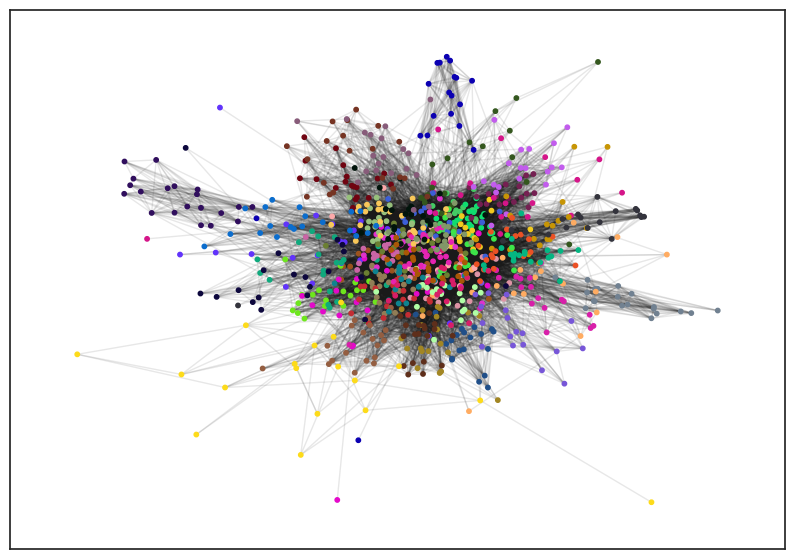

In [18]:
random.seed(1)

# Initialize colors dictionary
colors = {}

for com in communities_subreddits.keys():
    color = "#%06X" % random.randint(0, 0xFFFFFF) # creates random RGB color
    for node in communities_subreddits[com]:  # fill colors dictionary with the particular color for the community nodes
        colors[node] = color

# Create a list of colors for the nodes in the graph
node_colors = [colors[node] for node in G.nodes()]

pos = nx.spring_layout(G, iterations=15, seed=12)

plt.figure(figsize=(10, 7))
sns.set_style("ticks")
nx.draw_networkx_nodes(G, pos=pos, node_size=10, node_color=node_colors)
nx.draw_networkx_edges(G, pos=pos, alpha=0.1)
plt.show()

**Finding structural communities with Louvain algorithm**

In [19]:
# Find communities according to Louvain algorithm
communities_louvain = find_communities_louvain(G)
modularity_louvain = compute_modularity(G, communities_louvain)

print(f'Partion of the graph based on Louvain algorithm')
print(f'\tNumber of communities: {len(communities_louvain)} communities')
print(f'\tLargest community: {max([len(communities_louvain[community]) for community in communities_louvain])} posts')
print(f'\tSmallest community: {min([len(communities_louvain[community]) for community in communities_louvain])} posts')
print(f'\tModularity: {modularity_louvain:.4f}')

Partion of the graph based on Louvain algorithm
	Number of communities: 16 communities
	Largest community: 161 posts
	Smallest community: 17 posts
	Modularity: 0.3922


In [20]:
print(communities_louvain)

{0: ['1bderkj', '1ehd8ok', '1fcztmv', '1galm94', '1e5b14e', '1ba0vog', '1f0689m', '1ffiuck', '1coukwf', '1er16ro', '18r17fk', '1et9k3v', '1e490dv', '1fcp46t', '1bwwh10', '1ffut3a', '1g2rzw7', '1f8v70e', '1cwsco8', '1cegbcr'], 1: ['1bqny3d', '1b86dvb', '1eu3ca7', '1fj8y1v', '18ze3pp', '18njdsv', '1b58595', '17qxunx', '1asnrw8', '1eoohr4', '1fshk3l', '1ggfod3', '1f2nx55', '1ex1j1w', '1g0db5s', '1anpq8q', '1b96o21', '18d1bn1', '1akk79r', '1dgiz2d', '1914kz1', '1bgyk4b', '1epheya', '1e7ziws', '1axa9e1', '1egcld3', '17yfvey', '18jwigb', '1cq7c3r', '1ds9qn2', '18d270i', '1ghn4yi', '1b2j78q', '189fd9x', '1eiaheq', '19cf9g6', '1ekq4tr', '186ysi2', '19a881c', '1ggyhqa', '1c3vctw', '1g55t93', '1bsjm5a', '17t851u', '1bs8vvu', '1g0rhte', '1f3urh7', '18vaad5', '189ddry', '1fziepq', '1fkd8me', '1ahjsn2', '1by7zix', '1d4qswa', '195v7qk', '1bchomr', '1fyfhq2', '1b39yyj', '1ghrqep', '1dk63wk', '1eavj8d', '1am1s6y', '1gja4m1', '1g0u5mh', '1dnk4sh', '1c4jr17', '1e0yn87', '18qsc53', '1btf2dd', '1dvswvw', 

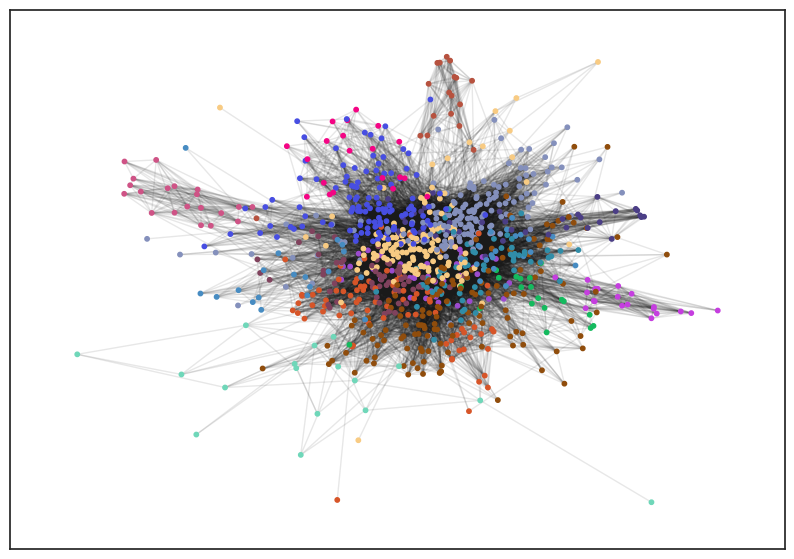

In [21]:
random.seed(0)

# Initialize colors dictionary
colors = {}

for com in communities_louvain.keys():
    color = "#%06X" % random.randint(0, 0xFFFFFF) # creates random RGB color
    for node in communities_louvain[com]:  # fill colors dictionary with the particular color for the community nodes
        colors[node] = color

# Create a list of colors for the nodes in the graph
node_colors = [colors[node] for node in G.nodes()]

pos = nx.spring_layout(G, iterations=15, seed=12)

plt.figure(figsize=(10, 7))
sns.set_style("ticks")
nx.draw_networkx_nodes(G, pos=pos, node_size=10, node_color=node_colors)
nx.draw_networkx_edges(G, pos=pos, alpha=0.1)
plt.show()

#### **Part 3.4: Wordclouds**

In [25]:
def get_n_most_common_communities(community_dict, n=1):
    """
    Get the n most common communities in the community dictionary
    
    Args
        community_dict: dictionary of communities (dict)
        n: number of most common communities to return (int)
        
    Returns
        most_common_communities: list of the n most common communities (list)
        community_to_artists: dictionary of genres to artists (dict)
    """

    # Get the counts of each genre in the community dictionary
    genre_counts = {genre: len(community_dict[genre]) for genre in community_dict}
    most_common_communities = sorted(genre_counts, key=genre_counts.get, reverse=True)[:n]

    # Dictionary of genres to artists
    community_to_artists = {genre: community_dict[genre] for genre in most_common_communities}
    
    return community_to_artists

**Find most common communities subreddits**

In [67]:
# Common communities according to the subreddit
most_common_communities_subreddits = get_n_most_common_communities(communities_subreddits, n=4)
print(f"Most common communities according to subreddit:")
for subreddit, posts in most_common_communities_subreddits.items():
    print(f"Subreddit: {subreddit}, Number of posts: {len(posts)}")

Most common communities according to subreddit:
Subreddit: Advice, Number of posts: 20
Subreddit: editors, Number of posts: 20
Subreddit: tifu, Number of posts: 20
Subreddit: Michigan, Number of posts: 20


**Find most common communities Louvain**

In [35]:
# Common communities according to the Louvain algorithm
most_common_communities_louvain = get_n_most_common_communities(communities_louvain, n=10)
print(f"\nMost common communities according to the Louvain algorithm:")
for community, posts in most_common_communities_louvain.items():
    print(f"Community: {community}, Number of posts: {len(posts)}")


Most common communities according to the Louvain algorithm:
Community: 3, Number of posts: 161
Community: 4, Number of posts: 140
Community: 11, Number of posts: 139
Community: 10, Number of posts: 120
Community: 1, Number of posts: 81
Community: 13, Number of posts: 60
Community: 14, Number of posts: 60
Community: 15, Number of posts: 41
Community: 6, Number of posts: 40
Community: 12, Number of posts: 40


**Create the stacked text files**

In [68]:
def create_stacked_text_files(most_common_genres, path, output_dir):
    """
    Create text files with the stacked text of the most common communities.
    
    Args
        communities: dictionary of communities (dict)
        most_common_genres: dictionary of the most common genres (dict)
        path: path to the data directory (str)
        output_dir: directory to save the text files (str)
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for subreddit, posts in most_common_genres.items():
        print(f"Creating text file for {subreddit} community")
        with open(os.path.join(output_dir, f"{subreddit}.txt"), "w", encoding="utf-8") as f:
            for post in posts:
                print(f"{G.nodes[post]['title']}", file=f)
                print(f"{G.nodes[post]['text']}", file=f)

                for comment in G.nodes[post]['comments']:
                    print(f"{comment['body']}", file=f)

create_stacked_text_files(most_common_communities_subreddits, "data", "subreddit_communities")

Creating text file for Advice community
Creating text file for editors community
Creating text file for tifu community
Creating text file for Michigan community


**Create Term frequency for communities**

In [69]:
def tokenize_text(text):
    """
    Tokenize a text into words using NLTK's word_tokenize function.

    Args:
        text: clean text to be tokenized (str)

    Returns:
        tokens: tokenized text (list)
    """

    # Tokenize the text
    tokens = nltk.tokenize.word_tokenize(text)

    # Remove punctuation tokens
    tokens = [token for token in tokens if token.isalnum()]

    # Set tokens to lowercase
    tokens = [token.lower() for token in tokens]

    # Lemmatize tokens using NLTK's WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

def calc_term_frequency(file, log_normalize=False, save=False, output_dir=None):
    """
    Calculate the term frequency of a text file and return a dictionary with the frequency of each token.

    Args:
        file: path to the text file (str)
        log_normalize: whether to log normalize the term frequencies (bool)
    """
    
    with open(file, "r", encoding="utf-8") as f:
        text = f.read()

    tokens = tokenize_text(text)
    freq = Counter(tokens)

    if log_normalize:
        freq = {token: np.round(np.log(count+1),3) for token, count in freq.items()}
    else:
        freq = {token: count for token, count in freq.items()}

    if save:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        # save term frequency to a file (Format: token, frequency)
        with open(os.path.join(output_dir, f"{os.path.basename(file).replace('.txt', '_freq.txt')}"), "w", encoding="utf-8") as f:
            for token, frequency in freq.items():
                print(f"{token}, {frequency}", file=f)


    return freq


In [70]:
for subreddit in most_common_communities_subreddits:
    term_freq = calc_term_frequency(f"subreddit_communities/{subreddit}.txt", log_normalize=True, save=True, output_dir="subreddit_term_freq")
    print(f"Term frequency of the text file '{subreddit}.txt': {term_freq}")

Term frequency of the text file 'Advice.txt': {'my': 7.691, 'girlfriend': 4.691, 'said': 6.441, 'she': 8.681, 's': 7.973, 'not': 8.312, 'in': 8.464, 'a': 9.447, 'relationship': 6.895, 'at': 7.306, 'party': 4.419, 'so': 7.596, 'recently': 3.807, 'me': 7.37, '18m': 0.693, 'and': 9.389, 'gf': 4.205, '18f': 0.693, 'went': 5.268, 'to': 9.615, 'halloween': 1.792, 'i': 9.199, 'wa': 7.919, 'already': 5.886, 'uncomfortable': 3.829, 'with': 8.237, 'her': 8.416, 'going': 6.807, 'because': 6.987, 'bunch': 3.135, 'of': 8.682, 'were': 6.38, 'be': 8.343, 'there': 7.274, 'they': 7.499, 'try': 5.94, 'flirting': 2.89, 'even': 6.92, 'while': 6.028, 'work': 6.203, 'we': 6.629, 'got': 6.258, 'very': 6.37, 'drunk': 5.73, 'fast': 3.526, 'lightweight': 0.693, 'the': 9.42, 'room': 4.277, 'full': 4.511, 'guy': 6.138, 'co': 2.565, 'worker': 3.045, 'sitting': 3.367, 'together': 5.549, 'that': 8.84, 'told': 5.82, 'about': 7.496, 'absolutely': 5.384, 'do': 8.151, 'like': 7.598, 'also': 6.608, 'next': 5.425, 'it': 9

**Create IFD**

In [89]:
def calc_IDF(file_dir):
    '''
    Calculate the inverse document frequency (IDF) for each term in the corpus.
    
    Args:
    file_dir: str, path to the directory containing the term frequency files
    
    Returns:
    IDF: dict, dictionary containing the IDF values for each term
    '''
    N = len(os.listdir(file_dir))
    print(f"Number of documents: {N}")
    IDF = {}
    for file in os.listdir(file_dir):
        with open(os.path.join(file_dir, file), "r", encoding="utf-8") as f:
            lines = f.readlines()
        for line in lines:
            term = line.split(",")[0]
            if term in IDF:
                IDF[term] += 1
            else:
                IDF[term] = 1
    for term, count in IDF.items():
        IDF[term] = np.round(np.log10(N/count+1), 3)
    return IDF

In [90]:
IDF_temp = calc_IDF("subreddit_term_freq")
print(f"IDF values for the terms in the subreddit corpus: {IDF_temp}")

Number of documents: 4
IDF values for the terms in the subreddit corpus: {'my': 0.301, 'girlfriend': 0.301, 'said': 0.301, 'she': 0.301, 's': 0.301, 'not': 0.301, 'in': 0.301, 'a': 0.301, 'relationship': 0.301, 'at': 0.301, 'party': 0.301, 'so': 0.301, 'recently': 0.301, 'me': 0.301, '18m': 0.699, 'and': 0.301, 'gf': 0.301, '18f': 0.477, 'went': 0.301, 'to': 0.301, 'halloween': 0.368, 'i': 0.301, 'wa': 0.301, 'already': 0.301, 'uncomfortable': 0.301, 'with': 0.301, 'her': 0.301, 'going': 0.301, 'because': 0.301, 'bunch': 0.301, 'of': 0.301, 'were': 0.301, 'be': 0.301, 'there': 0.301, 'they': 0.301, 'try': 0.301, 'flirting': 0.368, 'even': 0.301, 'while': 0.301, 'work': 0.301, 'we': 0.301, 'got': 0.301, 'very': 0.301, 'drunk': 0.301, 'fast': 0.301, 'lightweight': 0.699, 'the': 0.301, 'room': 0.301, 'full': 0.301, 'guy': 0.301, 'co': 0.301, 'worker': 0.301, 'sitting': 0.301, 'together': 0.301, 'that': 0.301, 'told': 0.301, 'about': 0.301, 'absolutely': 0.301, 'do': 0.301, 'like': 0.301, 

**Create Wordclouds**

In [107]:
def calc_TF_IDF(file_path, IDF):
    """
    Calculate the TF-IDF values for each term in the corpus.
    
    Args:
    file_path, str, path to a file containing term frequency values
    IDF: dict, dictionary containing the IDF values for each term
    
    Returns:
    TF_IDF: dict, dictionary containing the TF-IDF values for each term
    """

    TF_IDF = {}
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
    for line in lines:
        term, TF = line.split(",")
        TF = float(TF)
        TF_IDF[term] = TF * IDF[term]
    return TF_IDF
def plot_wordclouds(file_dir, IDF, mask=None):
    """
    Plot word clouds for each community in the graph.
    
    Args:
        file_dir: str, path to the directory containing the term frequency files
        IDF: dict, dictionary containing the IDF values for each term
    """

    plt.figure(figsize=(20, 10))
    for i, path in enumerate(os.listdir(file_dir)):
        TF_IDF = calc_TF_IDF(os.path.join(file_dir, path), IDF)
        sorted_TF_IDF = dict(sorted(TF_IDF.items(), key=lambda item: item[1], reverse=True))
        # Filter out the wiki keywords and stopwords
        wiki_keywords = ['ref', 'scoperow', 'rowspan2', 'aligncenter', 'styletextaligncenter', 'classwikitable', 'plainrowheaders', 'rowspan3', 'scopecol',
                            'categorycountry', 'alignleft', 'alignright', 'stylefontsizesmaller', 'width45', 'rowspan2', 'styletextalign', 'aligncenternbsp']
        filtered_TF_IDF = {k: v for k, v in sorted_TF_IDF.items() if k not in wiki_keywords}
        stop_words = set(stopwords.words('english'))
        filtered_TF_IDF = {k: v for k, v in filtered_TF_IDF.items() if k not in stop_words}
        plt.subplot(3, 4, i+1)
        wordcloud = WordCloud(width=800, height=400, background_color='white', mask=mask).generate_from_frequencies(filtered_TF_IDF)
        plt.imshow(wordcloud)
        plt.title(path[:-4])
        plt.axis('off')
    plt.tight_layout()
    plt.show()   

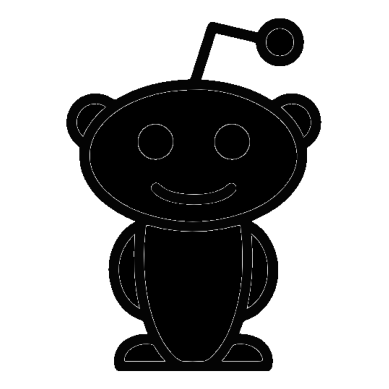

In [143]:
mask = np.array(Image.open("masks/reddit_icon.png").convert("L"))

plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

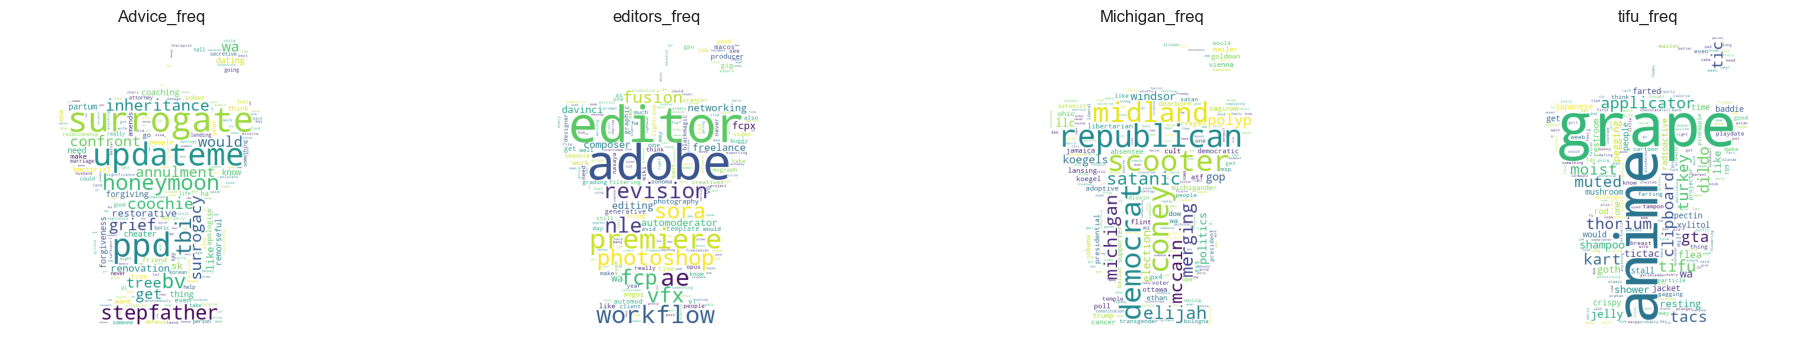

In [146]:
plot_wordclouds("subreddit_term_freq", IDF_temp, mask=mask)